# Making Transformers Efficient in Production
이번장에서는 PLM을 제품 및 서비스에 적용하기 위해 경량화하는 스킬들에 대해서 다뤄보고자합니다. 대체로 PLM은 SOTA의 좋은 성능을 갖지만, 사용하기엔 모델이 너무 크고 느려서 서비스 요구사항을 만족시키기 쉽지 않다는 어려움이 있습니다. 좀 더 빠르고 압축된 형태의 모델을 만들면 좋겠지만, 모델 크기를 줄이면 모델의 capacity 또한 감소하게 되고 전체적인 성능이 하락하게 될 수 있습니다. 이런 문제를 해결하기 위해 다음과 같은 많은 연구들이 진행되었습니다.
- knowledge distillation
- quantization
- pruning
- graph optimization

로블록스 팀에서 발표한 ["How We Scaled Bert To Serve 1+ Billion Daily Requests on CPUs"](https://blog.roblox.com/2020/05/scaled-bert-serve-1-billion-daily-requests-cpus/) 포스팅을 보면 knowledge distillation과 quantization을 적용했을때 30배 이상으로 처리량을 늘릴 수 있게 된것을 확인 할 수 있습니다.
![스케일링버트](https://blog.roblox.com/wp-content/uploads/2020/05/bert_1a.jpg)


## Intent Detection as a Case Study
인텐트 디텍션 문제를 예로 들면서, 모델 경량화 작업을 진행해보겠습니다. 베이스라인으로 CLINC150 dataset에 파인튜닝된 BERT-base 모델을 사용하겠습니다.

In [1]:
!pip install -q transformers[sentencepiece] datasets torch pandas optuna

     |████████████████████████████████| 3.4 MB 10.2 MB/s 
     |████████████████████████████████| 298 kB 75.1 MB/s 
     |████████████████████████████████| 308 kB 87.5 MB/s 
     |████████████████████████████████| 132 kB 79.2 MB/s 
     |████████████████████████████████| 1.1 MB 59.6 MB/s 
     |████████████████████████████████| 243 kB 68.9 MB/s 
     |████████████████████████████████| 61 kB 634 kB/s 
     |████████████████████████████████| 80 kB 10.3 MB/s 
     |████████████████████████████████| 209 kB 77.1 MB/s 
     |████████████████████████████████| 160 kB 69.9 MB/s 
     |████████████████████████████████| 271 kB 72.6 MB/s 
     |████████████████████████████████| 192 kB 72.1 MB/s 
     |████████████████████████████████| 75 kB 5.8 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 149 kB 93.7 MB/s 
     |████████████████████████████████| 112 kB 84.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.1 MB/s 
     |███████████████

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.549003541469574}]

## Creating a Performance Benchmark
다른 ML 모델들과 같이 트랜스포머모델을 배포하는건 몇가지 trade-off가 있습니다.
- Model Performance
- Latency
- Memory
위의 항목을 측정하기 위해 간단한 벤치마크를 만들어서 모델의 성능을 측정해보겠습니다.


In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [ ]:
from datasets import load_dataset
# oos는 out-of-scope의 약자로, 도메인에서 벗어난 데이터도 포함한 버전을 의미합니다
clinc = load_dataset("clinc_oos", "plus")

In [6]:
sample = clinc["test"][42]
sample

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

정답률을 체크하는 compute_accuracy 함수를 완성해보겠습니다

In [ ]:
from datasets import load_metric

accuracy_score = load_metric('accuracy')

In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

이제는 `torch.save()` 함수를 통해 모델의 크기를 측정하는 함수를 만들어보겠습니다. `torch.save()` 함수는 내부적으로 파이썬의 `pickle` 모듈을 사용합니다. 즉, 모델을 평범한 파이썬 오브젝트로 저장하는 것이 가능합니다. 파이토치에서는 모델을 저장할 때, `state_dict` 을 써서 저장하는 것을 추천하는데, `state_dict`은 파이썬 딕셔너리인데, 모델의 각 레이어와 모델의 파라미터(weight and biases)를 맵핑시켜줍니다. 예컨데, 베이스라인 모델의 state_dict에 저장된걸 확인해보면 다음과 같습니다.

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

모델은 다음과 같이 저장할 수 있습니다

In [11]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

파이썬 모듈인 `pathlib`에 있는 `Path.stat()` 함수를 통해 저장된 파일의 정보를 확인 할 수 있습니다. `Path("model.pt").stat().st_size` 를 통해 모델의 크기를 bytes 단위로 얻을 수 있습니다. 이를 기반으로 `compute_size()` 함수를 완성해보겠습니다.

In [12]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

이제 마지막으로 `time_pipeline()` 함수를 구현해보겠습니다. 질의당 평균 latency를 계산하는 함수입니다. 간단한 방법으로는 `perf_counter()` 함수를 통해 구현할 수 있고 `time.time()` 함수 보다 더 나은 time resolution을 갖기 때문에 더 정확한 결과를 얻을 수 있습니다.

In [13]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 85.152
Latency (ms) - 83.541
Latency (ms) - 75.503


실행할 때마다 결과가 조금씩 달라질 수 있기 때문에, 여러번 실행 후 분포에 대한 평균과 표준편차를 계산합니다. 제대로 된 실행시간 계산을 하기 전에 CPU를 warm up 시켜준 뒤 계산을 진행합니다.

In [14]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

간단한 테스트를 위해 `query`를 고정해서 진행하겠습니다. 보통 query length에 따라 latency가 달라지기 때문입니다. 하지만 제대로 된 평가를 원한다면 배포하고자하는 환경에서 들어오는 query로 테스트하는게 좋습니다.

이제 `PerformanceBenchmark` 클래스가 완성되었습니다. 이어서 벤치마크 테스트를 진행해보겠습니다.

# Benchmarking Our Baseline Model
베이스라인에 대해 accuracy, model size, latency등은 어느정도 나오는지 측정해보겠습니다

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 66.91 +\- 15.54
Accuracy on test set - 0.867


In [16]:
perf_metrics

{'BERT baseline': {'accuracy': 0.8672727272727273,
  'size_mb': 418.162091255188,
  'time_avg_ms': 66.90917849000016,
  'time_std_ms': 15.54450930778012}}

# Making Models Smaller via Knowledge Distillation
KD는 작은 크기를 갖는 모델이 큰 크기를 갖는 모델을 학생이 선생님께 배우듯 학습하는 방법론입니다. 2006년 "Model Compression" 이라는 논문에서 소개되었고, 2015년 Hinton 논문인 "Distilling the Knowledge in a Neural Network" 에서 쓰이면서 deep neural networks에 일반적으로 적용되게 되었습니다.


## Knowledge Distillation for Fine-Tuning
logits을 $\mathbf{z}(x)=\left[z_{1}(x), \ldots, z_{N}(x)\right]$라 하고, $T$를 temperature hyperparameter라고 하면 softmax 함수는 다음과 같이 표현할 수 있습니다.

$$
p_{i}(x)=\frac{\exp \left(z_{i}(x) / T\right)}{\sum_{j} \exp \left(z_{i}(x) / T\right)}
$$

$T$는 전체적인 확률분포를 고르게 보정해주는 역할을 하는데, 값에 따라서 확률분포는 다음과 같이 변할 수 있습니다.
![temperature_scaling](https://user-images.githubusercontent.com/7252598/146838210-eea51077-8916-4410-85bf-9493241d1627.png)

학생모델도 확률값을 $q_{i}(x)$ 갖기 때문에 [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)를 선생모델의 확률값과의 차이를 측정하는데 사용할 수 있습니다.
$$
D_{K L}(p, q)=\sum_{i} p_{i}(x) \log \frac{p_{i}(x)}{q_{i}(x)}
$$

KD divergence를 loss로 적용하면 다음과 같습니다. 여기서 $T^2$는 soft labels scales로 normalization factor입니다.

$$
L_{K D}=T^{2} D_{K L}
$$


분류 태스크에서 학생모델의 loss는 distillation loss와 일반적인 cross entropy loss인 $L_{CE}$ 대한 weighted average loss입니다.

$$
L_{\text {student }}=\alpha L_{C E}+(1-\alpha) L_{K D}
$$

![student_loss](https://user-images.githubusercontent.com/7252598/146839084-ef89b2f2-fe08-4811-9cc5-54566fd908f8.png)


## Knowledge Distillation for Pretraining
MLM에 대한 knowledge를 학생모델로 옮기는 것도 가능합니다. 여러 방법이 있지만, DistilBERT 논문에서의 방법은 다음과 같습니다.

$$
L_{\text {DistilBERT }}=\alpha L_{m l m}+\beta L_{K D}+\gamma L_{\cos }
$$

여기서 $L_{cos} = 1 - \cos(h_{s}, h_{t})$ 는 hidden state vectors의 방향을 align해주기 위한 텀입니다.

## Creating a Knowledge Distillation Trainer
이제부터 KD를 구현하기위해 기존 `Trainer`에 몇가지 기능을 추가해서 만들어보겠습니다.




In [17]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## Choosing a Good Student Initialization
일반적으로는 학생모델과 선생모델이 같은 모델타입을 가질때 KD가 잘 되는편입니다. 다른 모델의 경우 embedding spaces가 다르기 때문에 선생모델을 따라하기가 어렵습니다. 따라서 앞으로는 BERT 계열의 모델로 테스트를 진행하겠습니다.

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [20]:
# from huggingface_hub import notebook_login

# notebook_login()

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

처음 warm up 스테이지에서는 $\alpha = 1$로 셋팅해서 DistilBERT가 티처모델의 도움을 받지 않을때 어느정도 해내는지 확인해보겠습니다.

In [22]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=False) # push를 원하면 True로 바꿔줍니다

In [23]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [24]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

trainer내에서 여러번 실행할 것이기 때문에 `student_init()`함수를 만들어줍니다. 

In [25]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [26]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

In [28]:
# distilbert_trainer.push_to_hub("Training completed!")

In [ ]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [30]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 23.57 +\- 1.51
Accuracy on test set - 0.858


In [31]:
perf_metrics

{'BERT baseline': {'accuracy': 0.8672727272727273,
  'size_mb': 418.162091255188,
  'time_avg_ms': 66.90917849000016,
  'time_std_ms': 15.54450930778012},
 'DistilBERT': {'accuracy': 0.8581818181818182,
  'size_mb': 255.8870096206665,
  'time_avg_ms': 23.56640914000309,
  'time_std_ms': 1.5127073845396601}}

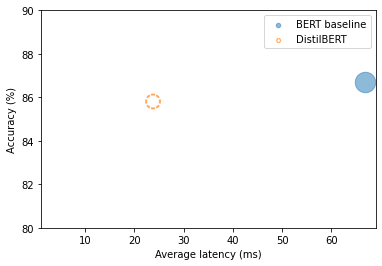

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

# Finding Good Hyperparameters with Optuna
각 모델과 데이터에 맞는 $\alpha$와 $T$를 찾기 위해 2D parameter space에 대해 grid search를 수행할 수 있습니다. 하지만 이보다 더 좋은 대안은 *Optuna*라는 최적화 프레임워크를 사용하는 것입니다. Optuna는 여러번의 시도를 통해 objective function을 최적화하는 방법으로 문제를 해결하빈다. 예컨데, [Rosenbrock’s “banana function”](https://en.wikipedia.org/wiki/Rosenbrock_function)을 최소화하는 문제를 풀어보겠습니다.

$$
f(x, y)=(1-x)^{2}+100\left(y-x^{2}\right)^{2}
$$

![banana_func](https://user-images.githubusercontent.com/7252598/146873268-5e2f431f-1e68-4e01-99e3-d2314cb143ac.png)

그림과 수식에서 볼 수 있듯이 $(x, y) = (1, 1)$일 때 함수는 global minimum을 갖는것을 알 수 있습니다.

Optuna에서는 $f(x,y)$ 함수의 최소값을 찾기 위해 `objective()` 함수를 정의 할 수 있습니다.


In [33]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

`trial.suggest_float`은 파라미터의 특정 구간에 대해서 유니폼분포로 샘플링한 값으로 최적화된 파라미터의 값을 추정합니다. `suggest_int`, `suggest_categorical` 등의 함수도 지원합니다.

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=100) # 1000

In [35]:
study.best_params

{'x': 0.5300448714793131, 'y': 0.3003762843294947}

`Trainer` 를 사용하면 좀 더 쉽게 hyperparameter search를 적용할 수 있습니다. 
더 높은 accuracy를 얻는 것이 목적이므로 `hyperparameter_search()` 함수 내에서 `direction="maximize"`로 셋팅합니다.

In [38]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=3, direction="maximize", hp_space=hp_space) # n_trials=20

In [40]:
print(best_run)

BestRun(run_id='0', objective=0.8941935483870967, hyperparameters={'num_train_epochs': 5, 'alpha': 0.23624395720945324, 'temperature': 16})


In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

In [42]:
# distil_trainer.push_to_hub("Training complete")

In [ ]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

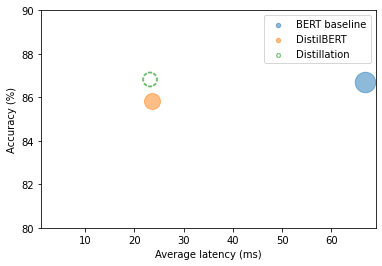

In [44]:
plot_metrics(perf_metrics, optim_type)

# Making Models Faster with Quantization

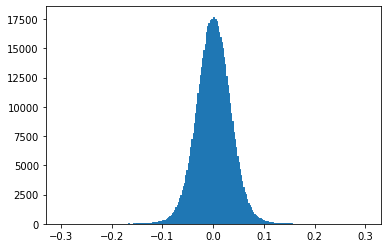

In [45]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [46]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [47]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [48]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [49]:
%%timeit
weights @ weights

100 loops, best of 5: 5.59 ms per loop


quantized tensors를 위해 `QFunctional` wrapper class를 사용할 수 있다.

In [50]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [51]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

The slowest run took 33.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 206 µs per loop


In [52]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999633833760527

In [ ]:
from torch.quantization import quantize_dynamic
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

# Benchmarking Our Quantized Model


In [54]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.40
Average latency (ms) - 13.93 +\- 1.17
Accuracy on test set - 0.876


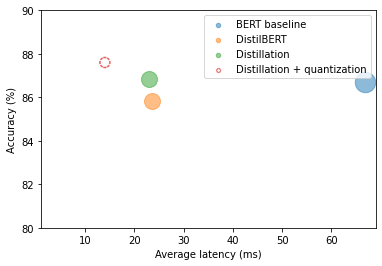

In [55]:
plot_metrics(perf_metrics, optim_type)

# Optimizing Inference with ONNX and the ONNX Runtime
ONNX는 연산 그래프(computational graph)를 standardized operators와 data types들로 추출해주는 프레임워크입니다. PyTorch와 TensorFlow간의 모델도 어느정도 스위칭 할 수 있습니다.


![image](https://user-images.githubusercontent.com/7252598/146886460-851d758c-a5f4-40a0-b089-ae1cbd23ca43.png)

ONNX는 ONNX Runtime 또는 ORT 같은 accelerator와 결합될 때 빛을 바랍니다. ORT는 ONNX 그래프를 최적화하는 툴입니다. 

![image](https://user-images.githubusercontent.com/7252598/146886908-f8746fbb-24f2-49d3-ac1c-2a3cb63bbfa0.png)

transformers library에는 ONNX를 `convert_graph_to_onnx.convert()`라는 빌트인함수를 통해 사용할 수 있습니다. 이 함수를 쓰기 위한 몇가지 조건은 다음과 같습니다.

- 모델을 `Pipeline` 형태로 초기화할 것
- Dummy inputs을 파이프라인에 입력해서 ONNX가 연산그래프를 기록할 수 있게 할 것
- dynamic axes를 정의해서 dynamic sequence lengths에 대응할 수 있게 할 것
- 그래프를 network parameters와 저장할 것

onnx를 사용하기 위해선 OpenMP 환경변수를 셋팅해줘야합니다. OpenMP는 고수준의 병렬화 어플리케이션을 개발하기 위해 설계된 API입니다. 다음과 같이 셋팅합니다.


In [56]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

ONNX는 immutable operator 스펙을 그룹핑하기 위해 operator sets을 사용합니다. `opset=12`는 ONNX library의 특정 버전에 대응되는 값입니다. (중요)

In [ ]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

이제 모델을 저장하기 위해 inference session을 생성해서 inputs을 모델에 입력하겠습니다.

In [ ]:
!pip install onnx
!pip install onnxruntime

In [59]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [60]:
onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [62]:
np.argmax(logits_onnx)

61

In [63]:
clinc_enc["test"][0]["labels"]

61

ONNX 모델은 `text-classification` pipeline과 호환되지 않기 때문에, 비슷한 기능의 클래스를 직접 생성해줍니다.

In [64]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [65]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7848334}]

기존에 사용하던 `PerformanceBenchmark` 클래스의 함수들은 사용하고, `compute_size()`를 오버라이딩 해줍니다. 기존 `compute_size()` 함수는 `state_dict`과 `torch.save()` 기반으로 동작했기 때문에, ONNX에 맞게 변경합니다. `onnx_model`은 ONNX의 `InferenceSession` object기 때문에, PyTorch의 `nn.Module` 속성에는 접근할 수 없습니다. 

In [66]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [67]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 23.09 +\- 1.07
Accuracy on test set - 0.868


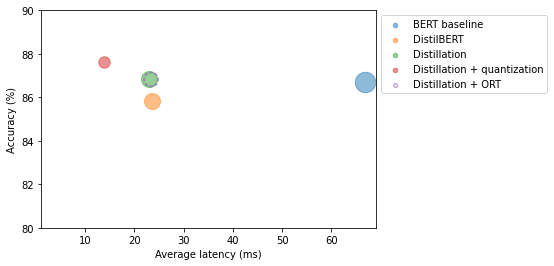

In [68]:
plot_metrics(perf_metrics, optim_type)

quantization을 적용해서 onnx 포멧으로 변경해보겠습니다.

In [69]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [70]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.20
Average latency (ms) - 14.75 +\- 2.25
Accuracy on test set - 0.877


In [72]:
perf_metrics

{'BERT baseline': {'accuracy': 0.8672727272727273,
  'size_mb': 418.162091255188,
  'time_avg_ms': 66.90917849000016,
  'time_std_ms': 15.54450930778012},
 'DistilBERT': {'accuracy': 0.8581818181818182,
  'size_mb': 255.8870096206665,
  'time_avg_ms': 23.56640914000309,
  'time_std_ms': 1.5127073845396601},
 'Distillation': {'accuracy': 0.8683636363636363,
  'size_mb': 255.8870096206665,
  'time_avg_ms': 23.070342589967368,
  'time_std_ms': 1.6400368327444326},
 'Distillation + ORT': {'accuracy': 0.8683636363636363,
  'size_mb': 255.88444709777832,
  'time_avg_ms': 23.087787130011748,
  'time_std_ms': 1.0705494813903838},
 'Distillation + ORT (quantized)': {'accuracy': 0.8765454545454545,
  'size_mb': 64.20259952545166,
  'time_avg_ms': 14.749559870015219,
  'time_std_ms': 2.245130272348436},
 'Distillation + quantization': {'accuracy': 0.8761818181818182,
  'size_mb': 132.3966302871704,
  'time_avg_ms': 13.932592399978603,
  'time_std_ms': 1.1674458359456512}}

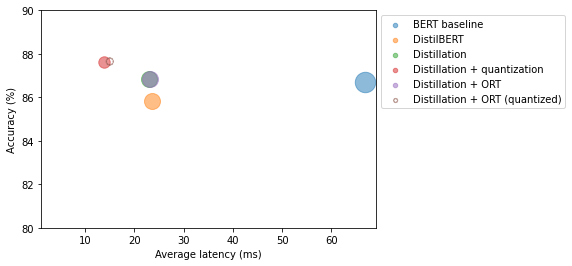

In [73]:
plot_metrics(perf_metrics, optim_type)

quantization을 적용할 때 모델 크기와 latency가 모두 감소하는 것을 확인할 수 있습니다. PyTorch는 `nn.Linear`모듈만 최적화하지만, ONNX는 embedding layer까지 quantization하기때문에 일반적으로는 효과가 좋습니다. 

이런 방법외에 다른 전략으로는 특정 weights를 지워버리는 weight pruning이라는 방법도 있습니다.